### MOUNT THE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/LN CLASSIFICATION'

### IMPORT ALL THE DEPENDENCIES

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np


### SET ALL THE CONSTANTS

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

### IMPORT DATA INTO TENSORFLOW

In [ ]:
images_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2586 files belonging to 5 classes.


In [ ]:
class_names=images_dataset.class_names
class_names

['LN CLASS 3', 'LN CLASS 4', 'LN CLASS 5', 'LN CLASS6', 'LUPUS NORMAL ']

In [ ]:
len(images_dataset)

81

In [ ]:
81*32

2592

### LABEL THE IMAGES IN DATASET

In [ ]:
for image_batch,label_batch in images_dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[3 1 4 3 3 4 3 3 4 3 4 3 3 4 4 4 4 0 4 4 4 4 3 3 4 3 3 4 4 3 3 4]


In [ ]:
for image_batch,label_batch in images_dataset.take(1):
  print(image_batch[0].numpy())

[[[181.       128.       180.      ]
  [171.86914  118.86914  170.03906 ]
  [148.4961    93.3457   145.7793  ]
  ...
  [163.58398   78.7168   143.58398 ]
  [159.83008   77.83008  139.83008 ]
  [159.        77.       139.      ]]

 [[186.81055  133.81055  185.81055 ]
  [177.67969  123.99066  175.84961 ]
  [153.71164   98.32617  150.99484 ]
  ...
  [164.64914   80.37695  144.64914 ]
  [161.49023   79.63129  141.49023 ]
  [160.66016   79.490234 140.66016 ]]

 [[204.48633  149.33594  202.76953 ]
  [194.16547  138.78     192.2136  ]
  [168.29063  111.93725  165.57384 ]
  ...
  [167.42358   84.70678  148.14038 ]
  [165.53586   85.13937  146.25266 ]
  [165.30078   85.734375 146.01758 ]]

 ...

 [[106.052734  48.335938 105.33594 ]
  [109.60812   51.061253 109.48633 ]
  [117.909904  58.99011  118.423706]
  ...
  [142.48866   61.63905  131.12524 ]
  [150.10672   67.653595 137.82352 ]
  [152.83203   69.54883  140.54883 ]]

 [[ 89.81055   32.810547  89.81055 ]
  [ 93.96094   36.13086   93.96094 ]


### VISUALIZE SOME OF THE IMAGES FROM DATASET

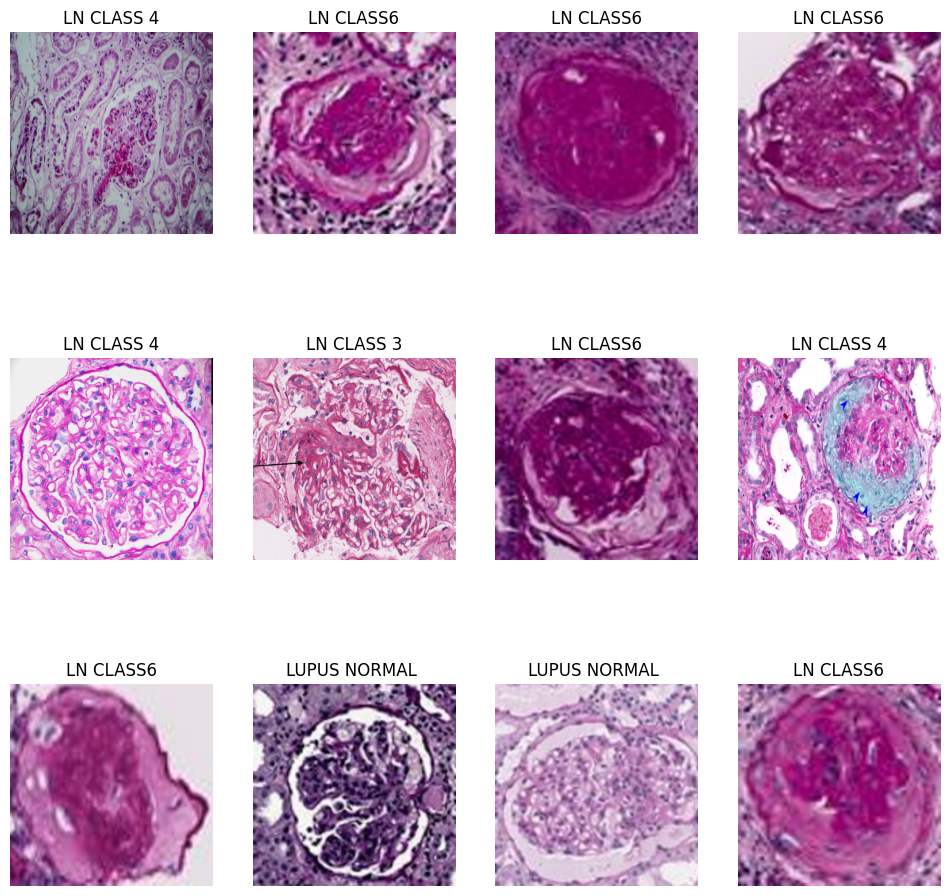

In [ ]:
#visualize the image in the batch
plt.figure(figsize=(12,12))
for image_batch,label_batch in images_dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

### FUNCTION TO SPLIT DATASET INTO TRAIN,TEST,VALIDATION

In [ ]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(images_dataset)

### LENGTH OF TRAIN,TEST,SPLIT DATA

In [ ]:
print(len(train_ds),len(val_ds),len(test_ds))

64 8 9


### INCREASE PERFORMANCE OF THE DATASET

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### LAYER FOR RESIZING AND NORMALIZATION

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

### DATA AUGMENTATION

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### BUILDING THE CNN MODEL

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### EVALUATION OF THE MODEL

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

### COMPILING THE MODEL

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30
64/64 [==============================] - 746s 5s/step - loss: 1.0458 - accuracy: 0.5356 - val_loss: 0.5954 - val_accuracy: 0.8086
Epoch 2/30
64/64 [==============================] - 280s 4s/step - loss: 0.5958 - accuracy: 0.7954 - val_loss: 0.4339 - val_accuracy: 0.8398
Epoch 3/30
64/64 [==============================] - 270s 4s/step - loss: 0.5138 - accuracy: 0.8354 - val_loss: 0.3372 - val_accuracy: 0.8711
Epoch 4/30
64/64 [==============================] - 271s 4s/step - loss: 0.3694 - accuracy: 0.8662 - val_loss: 0.6463 - val_accuracy: 0.7891
Epoch 5/30
64/64 [==============================] - 278s 4s/step - loss: 0.3107 - accuracy: 0.8701 - val_loss: 0.2786 - val_accuracy: 0.8867
Epoch 6/30
64/64 [==============================] - 274s 4s/step - loss: 0.2294 - accuracy: 0.8936 - val_loss: 0.2100 - val_accuracy: 0.9062
Epoch 7/30
64/64 [==============================] - 282s 4s/step - loss: 0.2277 - accuracy: 0.8940 - val_loss: 0.2191 - val_accuracy: 0.9180
Epoch 8/30
64

In [ ]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 40s 2s/step - loss: 0.1385 - accuracy: 0.9375


In [ ]:
scores

[0.13846440613269806, 0.9375]

### PLOTTING THE ACCURACY AND LOSS CURVES

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 64}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

30

In [ ]:
history.history['loss'][:5]

[1.0457764863967896,
 0.5957826375961304,
 0.5137996673583984,
 0.3693593740463257,
 0.31071892380714417]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

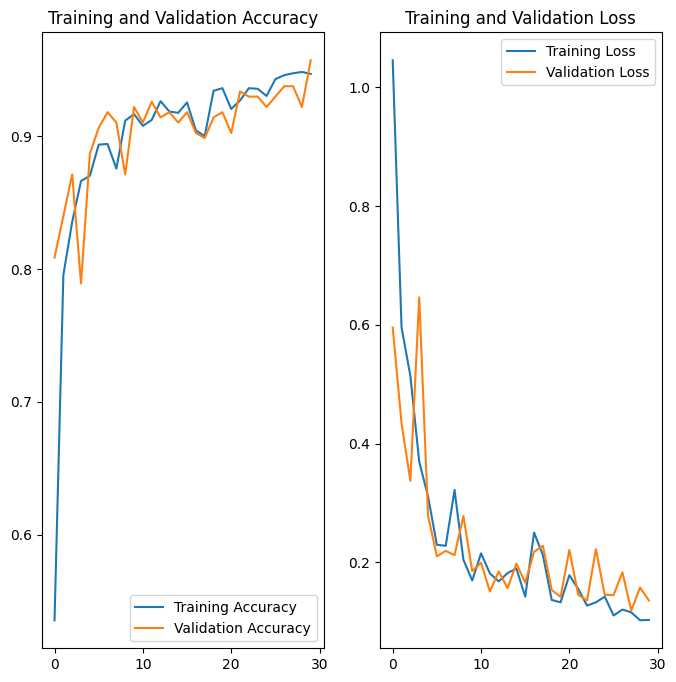

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### PREDICTION ON A SAMPLE

first image to predict
actual label: LUPUS NORMAL 
1/1 [==============================] - 1s 1s/step
predicted label: LUPUS NORMAL 


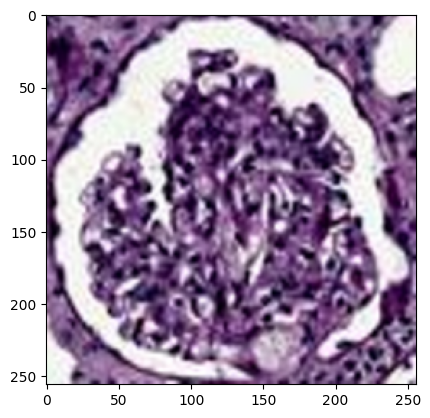

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### FUNCTION TO GET INFERENCE OF THE IMAGE

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


### VISUALIZING THE FINAAL INFERENCE ON THE SAMPLE IMAGES

1/1 [==============================] - 0s 49ms/step


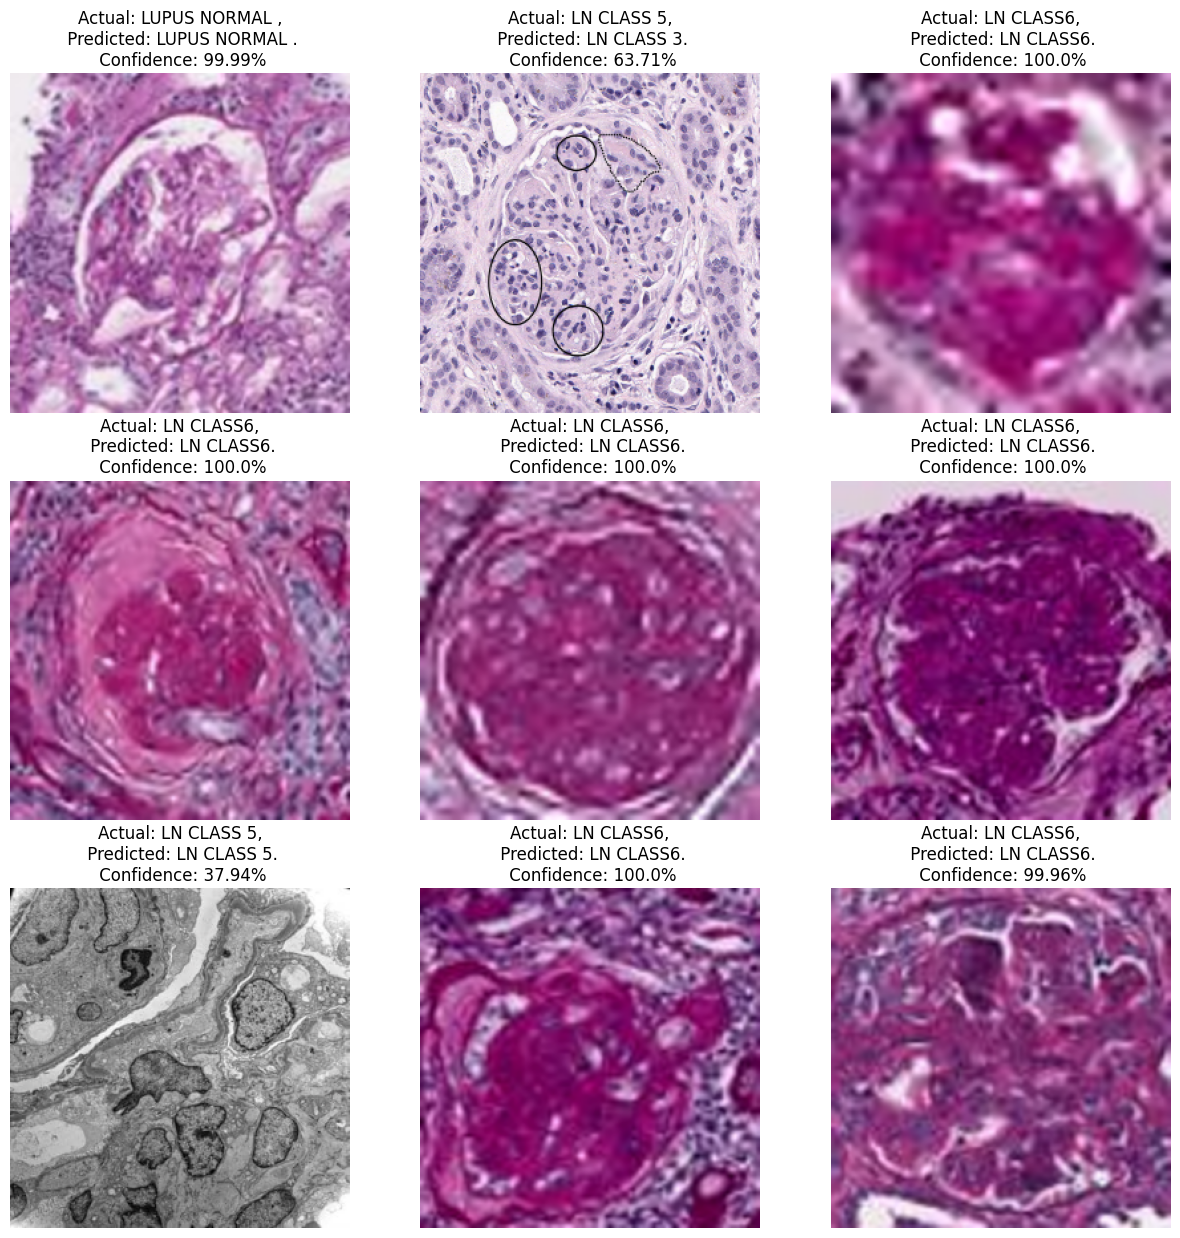

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

### SAVE THE MODEL

In [ ]:
model.save("../lupus.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
